This worksheet is to take the basic random forest benchmark work from Part 1 and add break out some additional featues to see if they improve the score.  

# Data Preprocessing

First I've imported all of fastai which includes pandas and numpy. Then I'll import some of the other functionality I'll need. Next I uploaded the train and test csv files as dataframes and then show their heads just to see what the columns contain. 

In [1]:
from fastai.imports import *

from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
#from sklearn.tree import DecisionTreeRegressor

In [2]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
import base64
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
import gc

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
import optuna
import xgboost as xgb
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, 
                              ExtraTreesClassifier, VotingClassifier)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn import datasets, linear_model
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

pd.set_option('display.max_columns', None)   

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import eli5
from eli5.sklearn import PermutationImportance

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

To separate the PassengerId out so I can use if for the Kaggle submission later, since it will be taken out of the test dataset. 

In [4]:
passengerid = pd.DataFrame(test['PassengerId'])

In [5]:
passengerid.head()

,PassengerId
0,0013_01
1,0018_01
2,0019_01
3,0021_01
4,0023_01


To combine the train and test datasets into one dataset for prepocessing work. 

In [6]:
train_test=train.append(test)

C:\Users\tompe\AppData\Local\Temp\ipykernel_10036\3828291759.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_test=train.append(test)


In [7]:
Expenses_columns = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']

To set all expenses to 0 if someone is in cryosleep, since they can't spend money then. 

In [8]:
train_test.loc[:,Expenses_columns]=train_test.apply(lambda x: 0 if x.CryoSleep == True else x,axis =1)

To create a new Expenses category that sums up all the other expenses. 

In [9]:
train_test['Expenses'] = train_test.loc[:,Expenses_columns].sum(axis=1)

For any expenses that are NaN and where cryosleep is true, those missing values will be made equal to zero. This appeared to eliminate all NaNs from expenses. I'm not sure how it did that for instances where CryoSleep was false????

In [10]:
train_test.loc[:,['CryoSleep']]=train_test.apply(lambda x: True if x.Expenses == 0 and pd.isna(x.CryoSleep) else x,axis =1)

In [11]:
train_test.isna().sum()

PassengerId        0
HomePlanet       288
CryoSleep        174
Cabin            299
Destination      274
Age              270
VIP              296
RoomService      170
FoodCourt        180
ShoppingMall     175
Spa              177
VRDeck           177
Name             294
Transported     4277
Expenses           0
dtype: int64

Here any missing names are filled with 'Unknown Unknown'.

In [12]:
train_test.Name = train_test.Name.fillna('Unknown Unknown')

This creates a new Room category which is simply the first four numbers of the PassengerID values. 

In [13]:
train_test.loc[:,['Room']] = train_test.PassengerId.apply(lambda x: x[0:4] )

This code creates the Cabin_y, VIP_y, HomePlanet_y and Destination_y columns which has the same information as their namesake columns. 

In [14]:
guide_VIP=train_test.loc[:,['Room','VIP']].dropna().drop_duplicates('Room')

In [15]:
guide_Cabin=train_test.loc[:,['Room','Cabin']].dropna().drop_duplicates('Room')
guide_HomePlanet=train_test.loc[:,['Room','HomePlanet']].dropna().drop_duplicates('Room')
guide_Destination=train_test.loc[:,['Room','Destination']].dropna().drop_duplicates('Room')
train_test=pd.merge(train_test,guide_Cabin,how="left",on='Room',suffixes=('','_y'))
train_test=pd.merge(train_test,guide_VIP,how="left",on='Room',suffixes=('','_y'))
train_test=pd.merge(train_test,guide_HomePlanet,how="left",on='Room',suffixes=('','_y'))
train_test=pd.merge(train_test,guide_Destination,how="left",on='Room',suffixes=('','_y'))

In [16]:
train_test.loc[:,['VIP']]=train_test.apply(lambda x: x.VIP_y if pd.isna(x.VIP) else x,axis=1)
train_test.loc[:,['Cabin']]=train_test.apply(lambda x:  x.Cabin_y if pd.isna(x.Cabin) else x,axis=1)
train_test.loc[:,['HomePlanet']]=train_test.apply(lambda x:  x.HomePlanet_y if pd.isna(x.HomePlanet) else x,axis=1)
train_test.loc[:,['Destination']]=train_test.apply(lambda x:  x.Destination_y if pd.isna(x.Destination) else x,axis=1)

To break out the 3 values in Cabin each into a new column. 

In [17]:
train_test.loc[:,['Cabin_1']] = train_test.Cabin.str.split("/",expand=True).iloc[:,0]
train_test.loc[:,['Cabin_2']] = train_test.Cabin.str.split("/",expand=True).iloc[:,1]
train_test.loc[:,['Cabin_3']] = train_test.Cabin.str.split("/",expand=True).iloc[:,2]

To break out Name into FirstName and SecondName columns. 

In [18]:
train_test.loc[:,['FirstName']] = train_test.Name.str.split(" ",expand=True).iloc[:,0]
train_test.loc[:,['SecondName']] = train_test.Name.str.split(" ",expand=True).iloc[:,1]

To create a Name_key column by combining the SecondName and Room values. I'm not sure why this was done. 

In [19]:
train_test['Name_key']=train_test['SecondName']+train_test['Room']

To identify the numeric and categorical columns that will be used for further processing. 

In [20]:
num_cols = ['ShoppingMall','FoodCourt','RoomService','Spa','VRDeck','Expenses','Age']
cat_cols = ['CryoSleep','Cabin_1','Cabin_3','VIP','HomePlanet','Destination']
transported=['Transported']

To create a new train_test dataset with only the columns identified above. 

In [21]:
train_test = train_test[num_cols+cat_cols+transported].copy()

To create the process for filling in the NaN values. 

In [22]:
num_imp = SimpleImputer(strategy='mean')
cat_imp = SimpleImputer(strategy='most_frequent')
ohe = OneHotEncoder (handle_unknown='ignore',sparse = False)

To fill all the missing values in the numberic categories. 

In [23]:
train_test[num_cols] = pd.DataFrame(num_imp.fit_transform(train_test[num_cols]),columns=num_cols)

To fill all the missing values in the categorical categories. But for some reason there were still missing values in Cabin_3 after this was run. 

In [24]:
train_test[cat_cols] = pd.DataFrame(cat_imp.fit_transform(train_test[cat_cols]),columns=cat_cols)

To use one hot encoding on the categorical columns and place those values in a temporary dataframe. 

In [25]:
temp_train = pd.DataFrame(ohe.fit_transform(train_test[cat_cols]),columns= ohe.get_feature_names_out())

To drop out the existing categorical columns and replace them with the one hot encoded columns from the temporary dataset. 

In [26]:
train_test = train_test.drop(cat_cols,axis=1)

In [27]:
train_test = pd.concat([train_test,temp_train],axis=1)

To recreate the train dataset by pulling in all the rows in train_test that include Transported values. 

In [28]:
train = train_test[train_test['Transported'].notnull()].copy()

To convert the boolean values of Transported into integers; go from True/False to 0/1. 

In [29]:
train.Transported =train.Transported.astype('int')

To recreate the test dataset by pulling all the rows in train_test where Transported have no values, and then drop the Transported column. However, the Transported column didn't seem to drop here. 

In [30]:
test = train_test[train_test['Transported'].isnull()].drop("Transported",axis=1)

To identify the independent and dependent variables. 

In [31]:
X = train.drop('Transported',axis=1)
y = train.Transported

In [32]:
test.head()

,ShoppingMall,FoodCourt,RoomService,Spa,VRDeck,Expenses,Age,CryoSleep_False,CryoSleep_True,Cabin_1_A,Cabin_1_B,Cabin_1_C,Cabin_1_D,Cabin_1_E,Cabin_1_F,Cabin_1_G,Cabin_1_T,Cabin_3_P,Cabin_3_S,Cabin_3_None,VIP_False,VIP_True,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
8693,0.0,0.0,0.0,0.0,0.0,0.0,27.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
8694,0.0,9.0,0.0,2823.0,0.0,2832.0,19.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
8695,0.0,0.0,0.0,0.0,0.0,0.0,31.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
8696,0.0,6652.0,0.0,181.0,585.0,7418.0,38.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
8697,635.0,0.0,10.0,0.0,0.0,645.0,20.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


# Utilizing the Model

I'll need to split the test dataset between the training and validation sections, with 25% being the percent allocated to validation. 

In [33]:

#trn_df,val_df = train_test_split(train, test_size=0.001)
#trn_df,val_df = train_test_split(train, test_size=0.05)
#trn_df,val_df = train_test_split(train, test_size=0.25)

In [33]:
random.seed(42)
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size=.25)

Finally, I import and run a basic random forest model on the data. The number of estimators is 100 and the minimum number of samples to split a node is at 5. I tried slightly higher and lower numbers for the samples and they came out worse. 

In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [57]:
"""parameters = {
    "n_estimators": [5, 10, 15, 20, 25], 
    "max_depth": [3, 5, 7, 9, 11, 12],
    "min_samples_leaf" : [18, 19, 20],
    "min_samples_split" : [8, 9, 10]
}


RFC_Model = RandomForestClassifier(random_state=0)
RFC_grid = GridSearchCV(RFC_Model, param_grid = parameters, cv = 5, scoring = 'accuracy', n_jobs= -1)
RFC_grid.fit(trn_xs, trn_y)
print('Best Parameters : ', RFC_grid.best_params_)
print()
print('Best Accuracy : ', RFC_grid.best_score_)"""

Best Parameters :  {'max_depth': 11, 'min_samples_leaf': 18, 'min_samples_split': 8, 'n_estimators': 25}

Best Accuracy :  0.7985902047657835


In [35]:
parameters = {
    "n_estimators": [25, 50, 100, 200, 300, 400, 500], 
    "max_depth": [2, 4, 8, 16, 32, 64],
    "min_samples_leaf" : [1, 5, 10, 20],
    "min_samples_split" : [2, 4, 10, 14, 18],
    "max_features": ['log2', 'sqrt', None],
    "criterion" : ["gini", "entropy"]
}

RFC_Model = RandomForestClassifier(random_state=0)
RFC_grid = GridSearchCV(RFC_Model, param_grid = parameters, cv = 5, scoring = 'accuracy', n_jobs= -1)
RFC_grid.fit(X_train, y_train)
print('Best Parameters : ', RFC_grid.best_params_)
print()
print('Best Accuracy : ', RFC_grid.best_score_)

Best Parameters :  {'criterion': 'entropy', 'max_depth': 32, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 50}

Best Accuracy :  0.8001211220920105


In [36]:
rf_model = RandomForestClassifier(criterion='entropy', 
                                  n_estimators=50,
                                  min_samples_split=2,
                                  min_samples_leaf=5,
                                  oob_score=True,
                                  max_depth=32,
                                  random_state=1,
                                  max_features='log2',
                                  n_jobs=-1)

In [37]:
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
accuracy_score(y_test, rf_predictions)

0.8178472861085556

In [55]:
"""rf_model.fit(trn_xs, trn_y)

rf_predictions = rf_model.predict(val_xs.values)
accuracy_score(val_y, rf_predictions)"""

C:\Users\tompe\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.7724137931034483

In [55]:
#rf = RandomForestClassifier(100, min_samples_leaf=5)
#rf.fit(trn_xs, trn_y);
#mean_absolute_error(val_y, rf.predict(val_xs))

One nice thing about random forests is that they can give you which variable has the biggest impact. This shows a number of the categories had a stronger impact. 

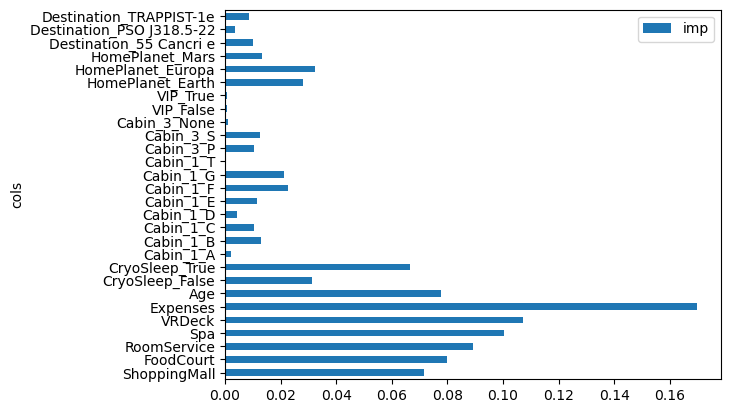

In [38]:
pd.DataFrame(dict(cols=X_train.columns, imp=rf_model.feature_importances_)).plot('cols', 'imp', 'barh');

# Create Submission File

To use the model to predict the Transported category in the test dataset. 

In [39]:
test['Transported'] = rf_model.predict(test)

In [40]:
passengerid

,PassengerId
0,0013_01
1,0018_01
2,0019_01
3,0021_01
4,0023_01
...,...
4272,9266_02
4273,9269_01
4274,9271_01
4275,9273_01


In [41]:
test['PassengerId'] = passengerid.values

In [42]:
test

,ShoppingMall,FoodCourt,RoomService,Spa,VRDeck,Expenses,Age,CryoSleep_False,CryoSleep_True,Cabin_1_A,Cabin_1_B,Cabin_1_C,Cabin_1_D,Cabin_1_E,Cabin_1_F,Cabin_1_G,Cabin_1_T,Cabin_3_P,Cabin_3_S,Cabin_3_None,VIP_False,VIP_True,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Transported,PassengerId
8693,0.0,0.0,0.0,0.0,0.0,0.0,27.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1,0013_01
8694,0.0,9.0,0.0,2823.0,0.0,2832.0,19.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,0018_01
8695,0.0,0.0,0.0,0.0,0.0,0.0,31.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1,0019_01
8696,0.0,6652.0,0.0,181.0,585.0,7418.0,38.000000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,0021_01
8697,635.0,0.0,10.0,0.0,0.0,645.0,20.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1,0023_01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,0.0,0.0,0.0,0.0,0.0,0.0,34.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1,9266_02
12966,17.0,847.0,0.0,10.0,144.0,1018.0,42.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0,9269_01
12967,0.0,0.0,0.0,0.0,0.0,0.0,28.771969,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1,9271_01
12968,0.0,2680.0,0.0,0.0,523.0,3203.0,28.771969,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,9273_01


This creates the actual submission file with this initial benchmark random forest model. 

In [43]:
submit_file = test[['PassengerId', 'Transported']]

In [44]:
submit_file['Transported'] = submit_file['Transported'].astype(int).astype(bool)

SettingWithCopyError: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [45]:
submit_file.head()

,PassengerId,Transported
8693,0013_01,True
8694,0018_01,False
8695,0019_01,True
8696,0021_01,True
8697,0023_01,True


In [46]:
submit_file.to_csv('submit_rfgridsearch_817data.csv', index=False)

The submission score was only 0.79705. 